In [1]:
#Cell 1 - Imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from matplotlib.pyplot import figure

Using TensorFlow backend.


In [2]:
#Cell 2 - LSTM Model
#Load train/dev/test

train_X= pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/train_X.csv')
dev_X = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/dev_X.csv')
test1_X = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/test1_X.csv')
test2_X = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/test2_X.csv')
train_Y = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/train_Y.csv')
dev_Y = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/dev_Y.csv')
test1_Y = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/test1_Y.csv')
test2_Y = pd.read_csv('/Users/gauravthapliyal/Desktop/Project Data/train_dev_test/Post_SARIMAX/test2_Y.csv')

train_X = train_X.loc[:, ~train_X.columns.str.contains('^Unnamed')]
dev_X = dev_X.loc[:, ~dev_X.columns.str.contains('^Unnamed')]
test1_X = test1_X.loc[:, ~test1_X.columns.str.contains('^Unnamed')]
test2_X = test2_X.loc[:, ~test2_X.columns.str.contains('^Unnamed')]
train_Y = train_Y.loc[:, ~train_Y.columns.str.contains('^Unnamed')]
dev_Y = dev_Y.loc[:, ~dev_Y.columns.str.contains('^Unnamed')]
test1_Y = test1_Y.loc[:, ~test1_Y.columns.str.contains('^Unnamed')]
test2_Y = test2_Y.loc[:, ~test2_Y.columns.str.contains('^Unnamed')]


_train_X = np.asarray(train_X).reshape((int(1117500/20), 20, 1))
_dev_X = np.asarray(dev_X).reshape((int(1117500/20), 20, 1))
_test1_X = np.asarray(test1_X).reshape((int(1117500/20), 20, 1))
_test2_X = np.asarray(test2_X).reshape((int(1117500/20), 20, 1))

_train_Y = np.asarray(train_Y).reshape(int(1117500/20), 1)
_dev_Y = np.asarray(dev_Y).reshape(int(1117500/20), 1)
_test1_Y = np.asarray(test1_Y).reshape(int(1117500/20), 1)
_test2_Y = np.asarray(test2_Y).reshape(int(1117500/20), 1)


train_loss = []
dev_loss = []
test1_loss = []
test2_loss = []

train_mse = []
dev_mse = []
test1_mse = []
test2_mse = []

train_mae = []
dev_mae = []
test1_mae = []
test2_mae = []

#Uncomment following lines if you want to start new epochs. If you want to continue on previous epochs, keep commented.

#dict = {'TRAIN_LOSS' : [], 'DEV_LOSS' : [], 'TEST1_LOSS' : [], 'TEST2_LOSS' : [], 'TRAIN_MSE' : [], 'DEV_MSE' : [], 'TEST1_MSE' : [], 'TEST2_MSE' : [], 'TRAIN_MAE' : [], 'DEV_MAE' : [], 'TEST1_MAE' : [], 'TEST2_MAE' : []}
#df = pd.DataFrame(dict)
#df.to_csv("/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM.csv")


class Double_Tanh(Activation):
    def __init__(self, activation, **kwargs):
        super(Double_Tanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'

def double_tanh(x):
    return (K.tanh(x) * 2)

get_custom_objects().update({'double_tanh':Double_Tanh(double_tanh)})

# Generate Model

#initialize a LSTM model
model = Sequential()
# describe input shape time steps, kernel and bias regularizer
model.add(LSTM(25, input_shape=(20,1), dropout=0.0, kernel_regularizer=l1_l2(0.00,0.00), bias_regularizer=l1_l2(0.00,0.00)))
model.add(Dense(1))
#describe the activation function. Note that this is the activation function of output gate and not the forget gate
model.add(Activation(double_tanh))
#compile model on mean square error and mean absolute error metric
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])

print(model.metrics_names)
# Fitting the Model
model_scores = {}

epoch_num=1
for _ in range(124):

    # train the model
    dir = '/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM'
    file_list = os.listdir(dir)
    if len(file_list) != 0 :
        epoch_num = len(file_list) + 1
        recent_model_name = 'epoch'+str(epoch_num-1)+'.h5'
        filepath = '/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM/' + recent_model_name
        model = load_model(filepath)

    filepath = '/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM/epoch'+str(epoch_num)+'.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='min')
    callbacks_list = [checkpoint]
    if len(callbacks_list) == 0:
        m = model.fit(_train_X, _train_Y, epochs=1, batch_size=500, shuffle=True)
        print('history :', m.history)
    else:
        m = model.fit(_train_X, _train_Y, epochs=1, batch_size=500, shuffle=True, callbacks=callbacks_list)
        print('history :', m.history)

    # Test model on train/dev/test1/test2
    score_train = model.evaluate(_train_X, _train_Y)
    score_dev = model.evaluate(_dev_X, _dev_Y)
    score_test1 = model.evaluate(_test1_X, _test1_Y)
    score_test2 = model.evaluate(_test2_X, _test2_Y)
    
    #Prediction Values for train/dev/test1/test2
    predTrain = model.predict(np.asarray(_train_X))
    predDev = model.predict(np.asarray(_dev_X))
    predTest1 = model.predict(np.asarray(_test1_X))
    predTest2 = model.predict(np.asarray(_test2_X))
    
    print(score_train)
    print('train set score : loss - ' + str(score_train[0]) + 'train set score : mse - ' + str(score_train[1]) +' / mae - ' + str(score_train[2]))
    print('dev set score : loss - ' + str(score_train[0]) + 'dev set score : mse - ' + str(score_dev[1]) +' / mae - ' + str(score_dev[2]))
    print('test1 set score : loss - ' + str(score_train[0]) + 'test1 set score : mse - ' + str(score_test1[1]) +' / mae - ' + str(score_test1[2]))
    print('test2 set score : loss - ' + str(score_train[0]) + 'test2 set score : mse - ' + str(score_test2[1]) +' / mae - ' + str(score_test2[2]))

    # get former score data
    df = pd.read_csv("/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM.csv")
    
    train_loss = list(df['TRAIN_LOSS'])
    dev_loss = list(df['DEV_LOSS'])
    test1_loss = list(df['TEST1_LOSS'])
    test2_loss = list(df['TEST2_LOSS'])
    
    train_mse = list(df['TRAIN_MSE'])
    dev_mse = list(df['DEV_MSE'])
    test1_mse = list(df['TEST1_MSE'])
    test2_mse = list(df['TEST2_MSE'])

    train_mae = list(df['TRAIN_MAE'])
    dev_mae = list(df['DEV_MAE'])
    test1_mae = list(df['TEST1_MAE'])
    test2_mae = list(df['TEST2_MAE'])
    
    print(score_train)
    # add new score data with the old data and update it back in the csv
    train_loss.append(score_train[0])
    dev_loss.append(score_dev[0])
    test1_loss.append(score_test1[0])
    test2_loss.append(score_test2[0])
    
    train_mse.append(score_train[1])
    dev_mse.append(score_dev[1])
    test1_mse.append(score_test1[1])
    test2_mse.append(score_test2[1])

    train_mae.append(score_train[2])
    dev_mae.append(score_dev[2])
    test1_mae.append(score_test1[2])
    test2_mae.append(score_test2[2])

    model_scores['TRAIN_LOSS'] = train_loss
    model_scores['DEV_LOSS'] = dev_loss
    model_scores['TEST1_LOSS'] = test1_loss
    model_scores['TEST2_LOSS'] = test2_loss
    
    model_scores['TRAIN_MSE'] = train_mse
    model_scores['DEV_MSE'] = dev_mse
    model_scores['TEST1_MSE'] = test1_mse
    model_scores['TEST2_MSE'] = test2_mse

    model_scores['TRAIN_MAE'] = train_mae
    model_scores['DEV_MAE'] = dev_mae
    model_scores['TEST1_MAE'] = test1_mae
    model_scores['TEST2_MAE'] = test2_mae

    model_scores_df = pd.DataFrame(model_scores)
    model_scores_df.to_csv("/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM.csv")

['loss', 'mse', 'mae']
Epoch 1/1
55875/55875 [==============================] - 3s 45us/step - loss: 0.0111 - mse: 0.0111 - mae: 0.0526

Epoch 00001: saving model to /Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM/epoch529.h5
history : {'loss': [0.011141892289221954], 'mse': [0.0111418925], 'mae': [0.052618474]}
55875/55875 [==============================] - 3s 48us/step
[0.011120344631995025, 0.011120340786874294, 0.05105083808302879]
train set score : loss - 0.011120344631995025train set score : mse - 0.011120340786874294 / mae - 0.05105083808302879
dev set score : loss - 0.011120344631995025dev set score : mse - 0.013408022001385689 / mae - 0.055261265486478806
test1 set score : loss - 0.011120344631995025test1 set score : mse - 0.014888466335833073 / mae - 0.05798334255814552
test2 set score : loss - 0.011120344631995025test2 set score : mse - 0.013245735317468643 / mae - 0.05450011044740677
[0.011120344631995025, 0.011120340786874294, 0.0510508380830287

KeyboardInterrupt: 

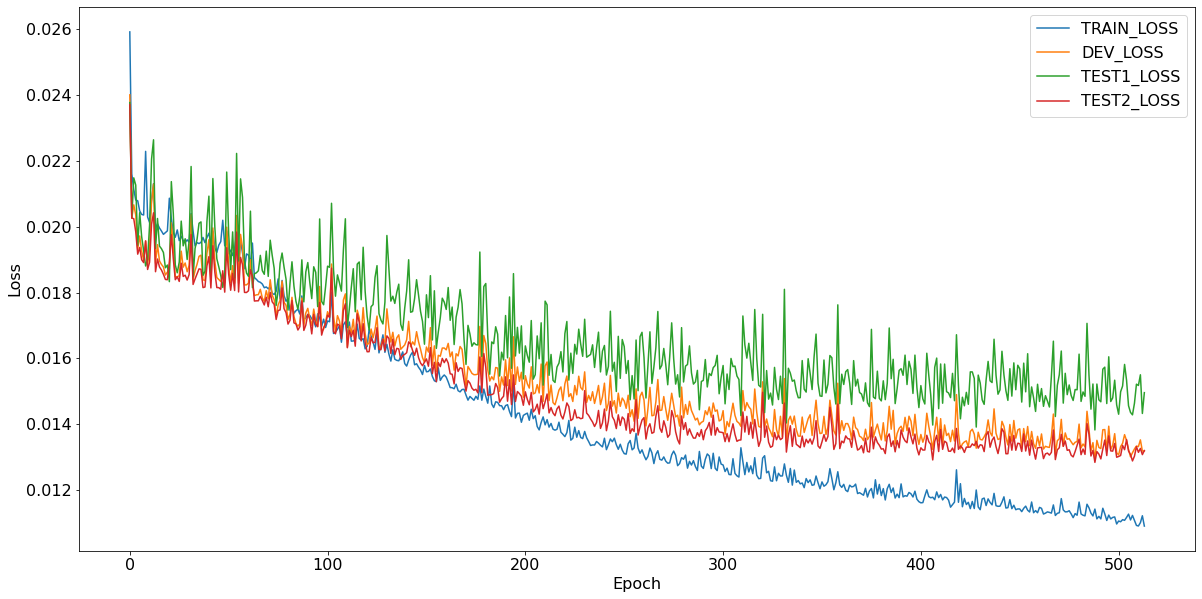

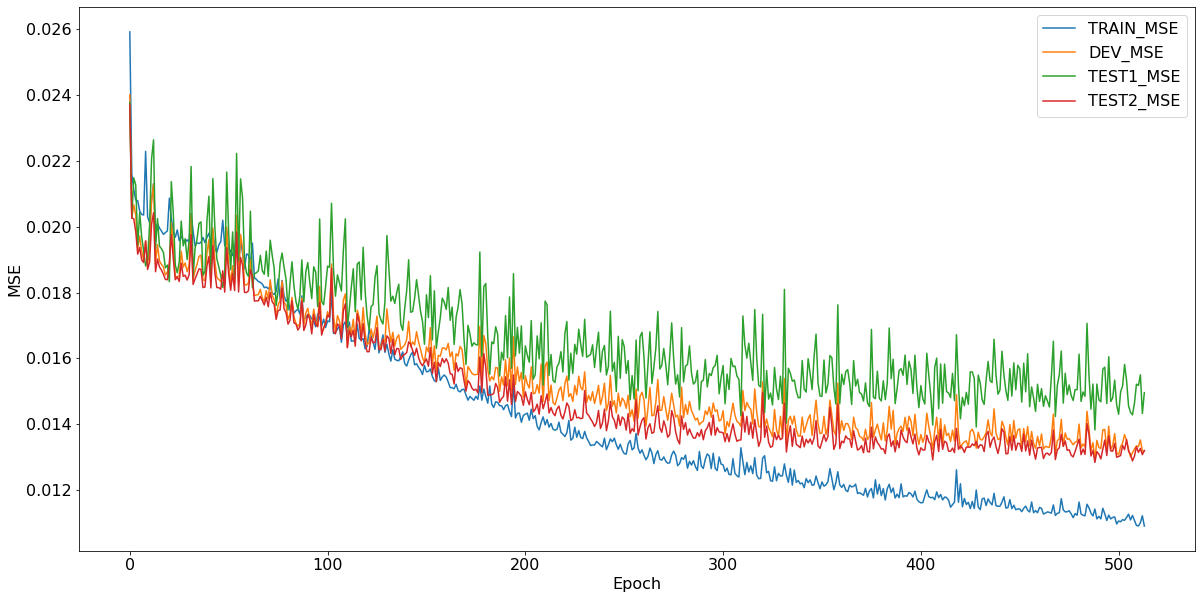

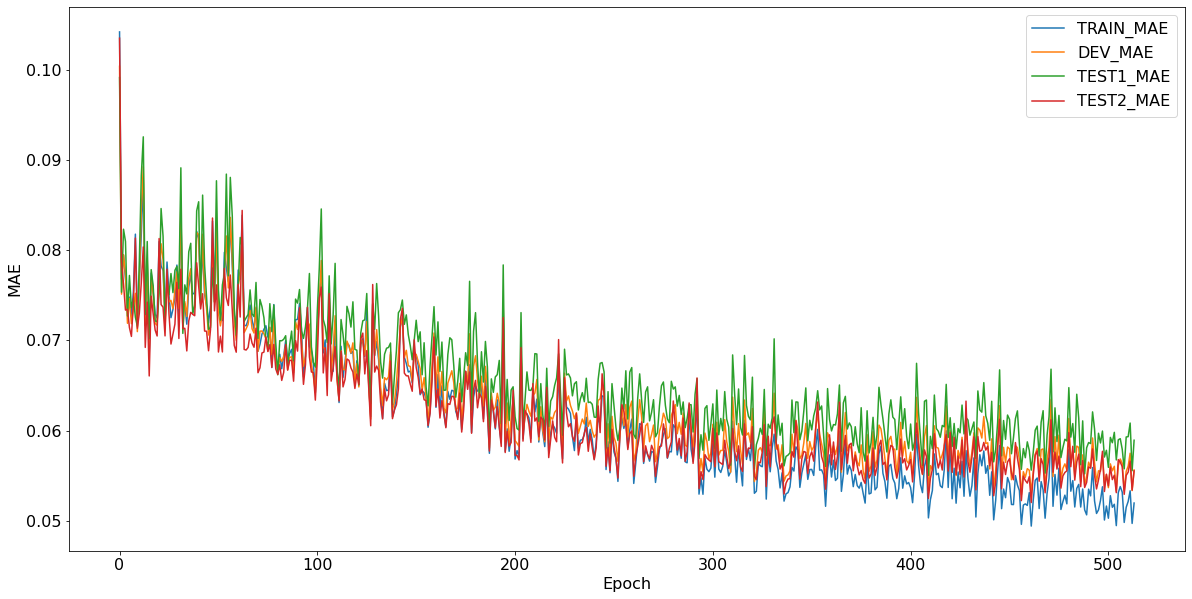

In [3]:
#Cell 3 - Plot loss, mae , mse for train/dev/test1/test2 learning curves

result = pd.read_csv("/Users/gauravthapliyal/Desktop/Project Data/LSTM-SARIMAX-models/hybrid_LSTM.csv")
columns = list(result)
ylabels = ["Loss", "MSE", "MAE"]
i = 1
j = 0
while i < 13:
    df.plot(x=columns[0], y=[columns[i], columns[i+1], columns[i+2], columns[i+3]], kind="line", figsize=(20,10))
    plt.xlabel("Epoch")
    plt.ylabel(ylabels[j])
    plt.show()
    i += 4
    j += 1

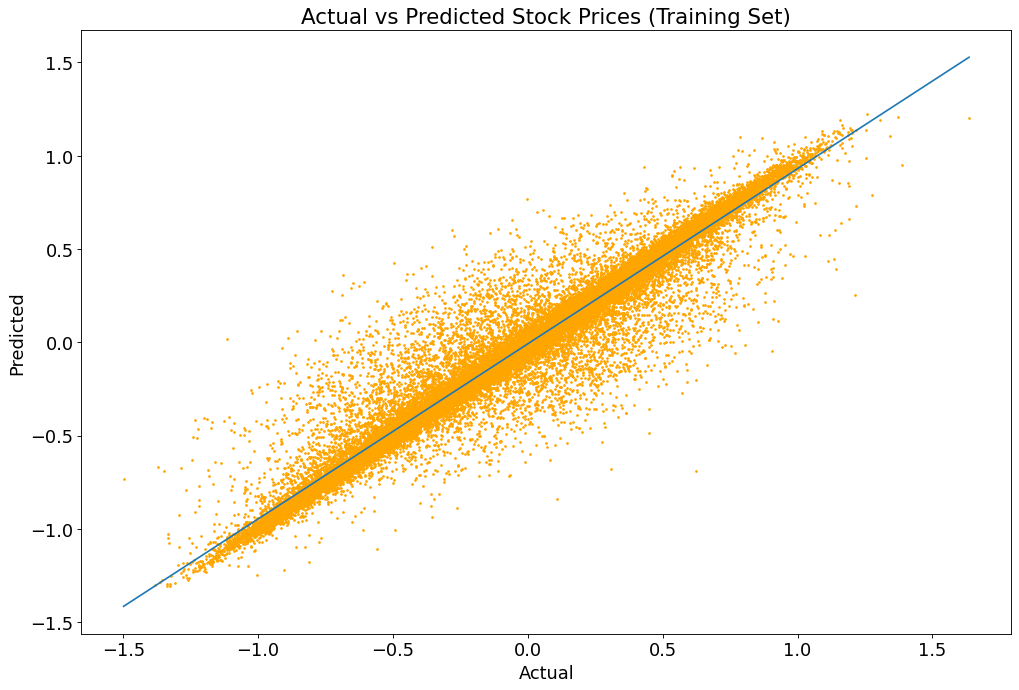

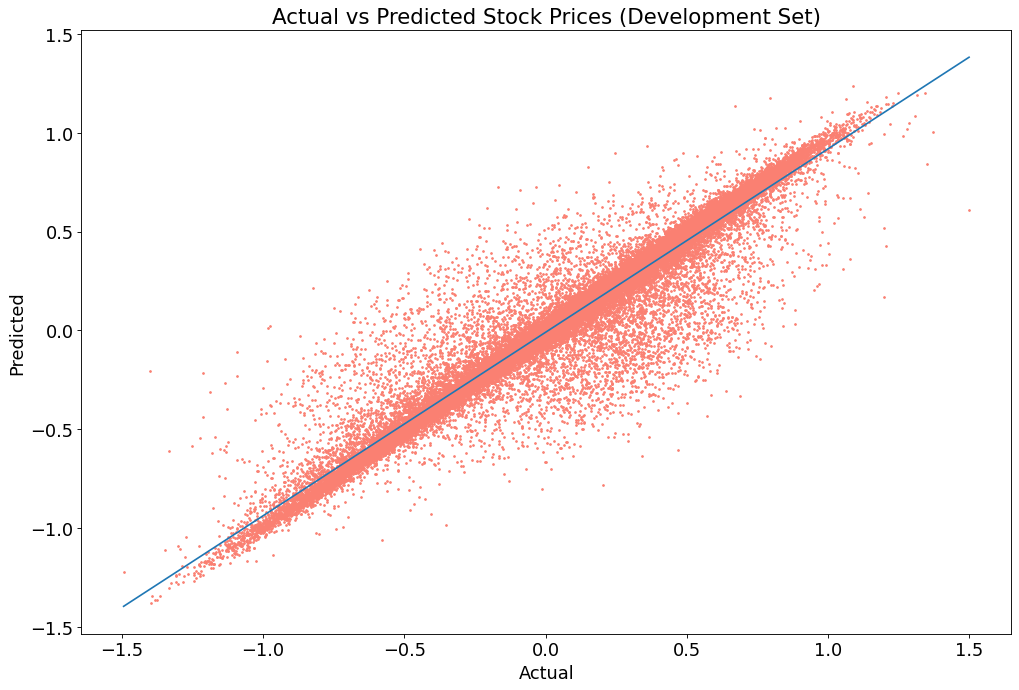

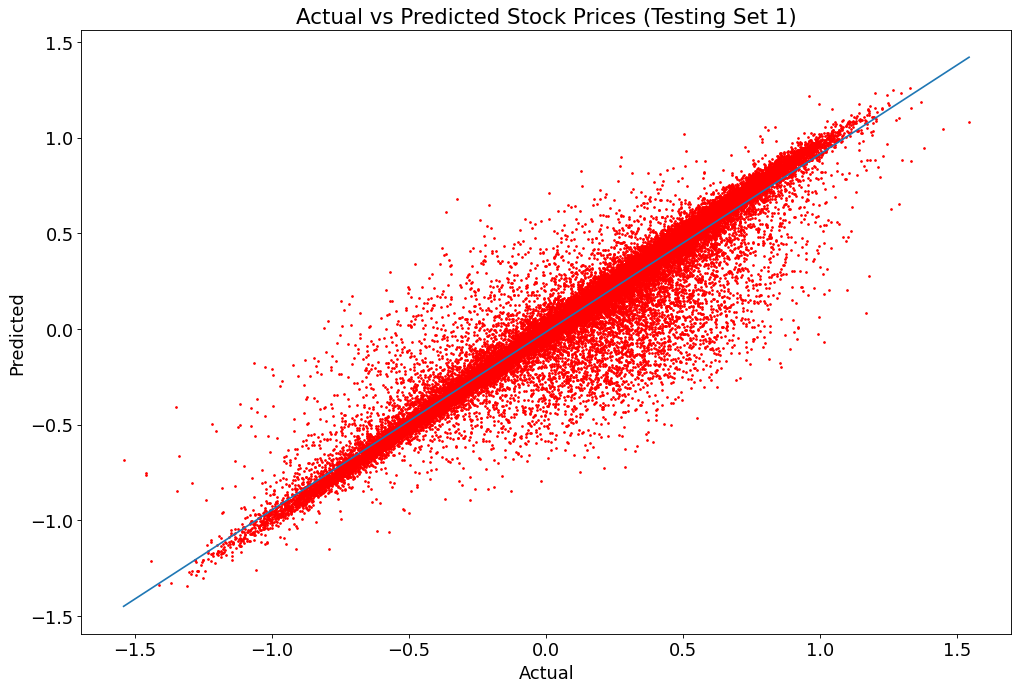

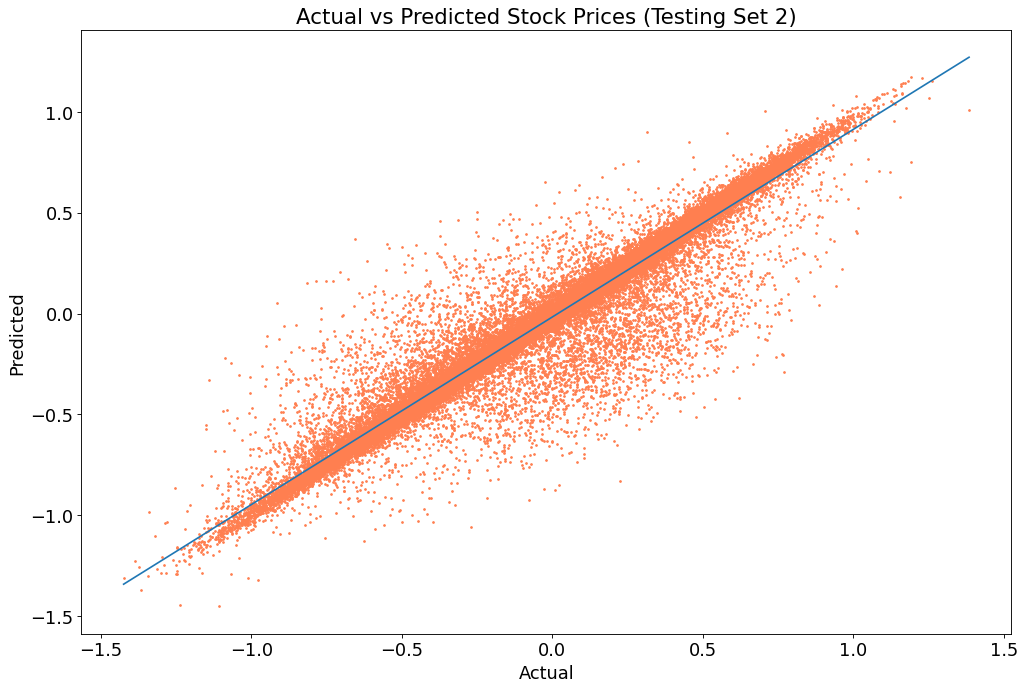

In [4]:
#Cell 4 - Plot scatter of actual vs predicted coefficients for train/dev/test1/test2 

p1 = predTrain.flatten() 
p2 = predDev.flatten()
p3 = predTest1.flatten() 
p4 = predTest2.flatten()

e1 = _train_Y.flatten()
e2 = _dev_Y.flatten()
e3 = _test1_Y.flatten()
e4 = _test2_Y.flatten()

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(e1, p1, color = "orange", s=2)
plt.title("Actual vs Predicted Stock Prices (Training Set)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.unique(e1), np.poly1d(np.polyfit(e1, p1, 1))(np.unique(e1)))
plt.show()

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(e2, p2, color = "salmon", s=2)
plt.title("Actual vs Predicted Stock Prices (Development Set)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.unique(e2), np.poly1d(np.polyfit(e2, p2, 1))(np.unique(e2)))
plt.show()

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(e3, p3, color = "red", s=2)
plt.title("Actual vs Predicted Stock Prices (Testing Set 1)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.unique(e3), np.poly1d(np.polyfit(e3, p3, 1))(np.unique(e3)))
plt.show()

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(e4, p4, color = "coral", s=2)
plt.title("Actual vs Predicted Stock Prices (Testing Set 2)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot(np.unique(e4), np.poly1d(np.polyfit(e4, p4, 1))(np.unique(e4)))
plt.show()